# Hello Image Classification

This basic introduction to OpenVINO™ shows how to do inference with an image classification models such as renset-50 (Tensorflow) and resnet-18 (PyTorch).

Refer to [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/) to download a wide range of pre-trained models and ready-to-run demos. For more information about how OpenVINO IR models are created, refer to the [TensorFlow to OpenVINO](../tensorflow-classification-to-openvino/tensorflow-classification-to-openvino.ipynb) tutorial.


#### Table of contents:

- [Imports](#Imports)
- [Download the Model and data samples](#Download-the-Model-and-data-samples)
- [Select inference device](#Select-inference-device)
- [Load the Model](#Load-the-Model)
- [Load an Image](#Load-an-Image)
- [Do Inference](#Do-Inference)



In [1]:
import platform

# Install openvino package
%pip install -q "openvino>=2023.1.0" opencv-python tqdm

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Imports
[back to top ⬆️](#Table-of-contents:)


In [1]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file

## Download the Model and data samples
[back to top ⬆️](#Table-of-contents:)


In [50]:
!omz_downloader --name resnet-50-tf -o ./artifacts

################|| Downloading resnet-50-tf ||################

========== Downloading artifacts\public\resnet-50-tf\resnet_v1-50.pb
... 1%, 1024 KB, 307 KB/s, 3 seconds passed
... 2%, 2048 KB, 408 KB/s, 5 seconds passed
... 3%, 3072 KB, 499 KB/s, 6 seconds passed
... 4%, 4096 KB, 573 KB/s, 7 seconds passed
... 5%, 5120 KB, 651 KB/s, 7 seconds passed
... 6%, 6144 KB, 728 KB/s, 8 seconds passed
... 7%, 7168 KB, 800 KB/s, 8 seconds passed
... 8%, 8192 KB, 862 KB/s, 9 seconds passed
... 9%, 9216 KB, 933 KB/s, 9 seconds passed
... 10%, 10240 KB, 997 KB/s, 10 seconds passed
... 11%, 11264 KB, 1072 KB/s, 10 seconds passed
... 12%, 12288 KB, 1136 KB/s, 10 seconds passed
... 13%, 13312 KB, 1205 KB/s, 11 seconds passed
... 14%, 14336 KB, 1262 KB/s, 11 seconds passed
... 15%, 15360 KB, 1330 KB/s, 11 seconds passed
... 16%, 16384 KB, 1396 KB/s, 11 seconds passed
... 17%, 17408 KB, 1458 KB/s, 11 seconds passed
... 18%, 18432 KB, 1520 KB/s, 12 seconds passed
... 19%, 19456 KB, 1580 KB/s, 12 seconds

In [51]:
! omz_converter --name resnet-50-tf -o ./artifacts -d ./artifacts --precision FP16

========== Converting resnet-50-tf to IR (FP16)
Conversion command: "C:\Users\rameshpe\OneDrive - Intel Corporation\Documents\Work\OpenVINO\ov_dev_2024_1\Scripts\python.exe" -- "C:\Users\rameshpe\OneDrive - Intel Corporation\Documents\Work\OpenVINO\ov_dev_2024_1\Scripts\mo.exe" --framework=tf --output_dir=artifacts\public\resnet-50-tf\FP16 --model_name=resnet-50-tf --input=map/TensorArrayStack/TensorArrayGatherV3 --mean_values=[123.68,116.78,103.94] --output=softmax_tensor --input_model=artifacts\public\resnet-50-tf/resnet_v1-50.pb --reverse_input_channels --layout=map/TensorArrayStack/TensorArrayGatherV3(NHWC) "--input_shape=[1, 224, 224, 3]" --compress_to_fp16=True

[ INFO ] Generated IR will be compressed to FP16. If you get lower accuracy, please consider disabling compression explicitly by adding argument --compress_to_fp16=False.
Find more information about compression to FP16 at https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_FP16_Compression.html
[ INFO ] MO command line to

## Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [2]:
import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

## Load the Model
[back to top ⬆️](#Table-of-contents:)


In [3]:
base_artifacts_dir = Path("./artifacts/public/resnet-50-tf/FP16/").expanduser()
file_name = "resnet-50-tf.xml"
model_xml_path = base_artifacts_dir / file_name
core = ov.Core()
model = core.read_model(model=model_xml_path)
compiled_model = core.compile_model(model=model, device_name=device.value)

output_layer = compiled_model.output(0)

## Load an Image
[back to top ⬆️](#Table-of-contents:)


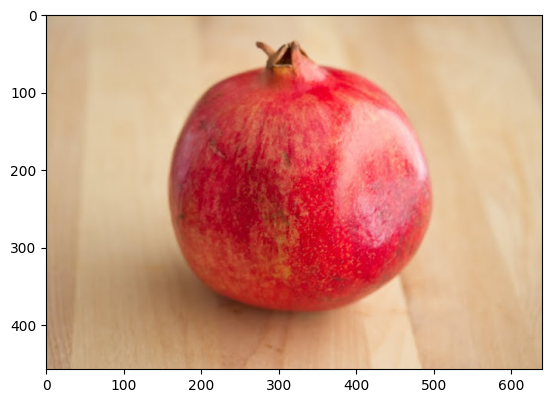

In [4]:
# Download the image from the openvino_notebooks storage
data_dir = Path("./data").expanduser()
image_filename = data_dir / "t3.jpg"
# The MobileNet model expects images in RGB format.
image = cv2.cvtColor(cv2.imread(filename=str(image_filename)), code=cv2.COLOR_BGR2RGB)

# Resize to MobileNet image shape
input_image = cv2.resize(src=image, dsize=(224, 224))
#input_image = input_image.transpose(2, 0, 1)

# Reshape to model input shape.
input_image = np.expand_dims(input_image, 0)
plt.imshow(image);

## Do Inference
[back to top ⬆️](#Table-of-contents:)


In [5]:
result_infer = compiled_model([input_image])[output_layer]
result_index = np.argmax(result_infer)

In [6]:
imagenet_filename = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/datasets/imagenet/imagenet_2012.txt",
    directory="data",
)

imagenet_classes = imagenet_filename.read_text().splitlines()
# The model description states that for this model, class 0 is a background.
# Therefore, a background must be added at the beginning of imagenet_classes.
imagenet_classes = ["background"] + imagenet_classes

'data\imagenet_2012.txt' already exists.


In [7]:
imagenet_classes[result_index]

'n07768694 pomegranate'

## Conversion of PyTorch Model using OpenVINO model conversion API  

In [5]:
import openvino as ov
import torch
from pathlib import Path
import torchvision
from torchvision.models import resnet18

# get default weights using available weights Enum for model
weights = torchvision.models.ResNet18_Weights.DEFAULT

# create model topology and load weights
model = resnet18(weights=weights)

# switch model to inference mode
model.eval()

# Convert model to openvino.runtime.Model object
ov_model = ov.convert_model(model, input=[[1, 3, 224, 224]])
prep = ov.preprocess.PrePostProcessor(ov_model)
prep.input("x").tensor().set_layout(ov.Layout("nchw"))
prep.input("x").preprocess().mean([123.675,116.28,103.53])
prep.input("x").preprocess().scale([58.395,57.12,57.375])
ov_model = prep.build()
base_artifacts_dir = Path("./artifacts/public/resnet-18-pytorch/ov_format/").expanduser()
ov_model_path = base_artifacts_dir / "resnet-18-pytorch.xml"
ov.save_model(ov_model,ov_model_path)

In [6]:
ov_model

<Model: 'Model10'
inputs[
<ConstOutput: names[x] shape[1,3,224,224] type: f32>
]
outputs[
<ConstOutput: names[x.45] shape[1,1000] type: f32>
]>

### Execute inference with PyTorch model

In [ ]:
from PIL import Image
import numpy as np
import torch
from pathlib import Path
import torchvision
from torchvision.models import resnet18

# get default weights using available weights Enum for model
weights = torchvision.models.ResNet18_Weights.DEFAULT

# create model topology and load weights
model = resnet18(weights=weights)

# switch model to inference mode
model.eval()

# Prepare Input Data
data_dir = Path("./data").expanduser()
image_filename = data_dir / "goldfish.jpg"
# The model expects images in RGB format.
image = Image.open(image_filename)

# Initialize the Weight Transforms
preprocess = weights.transforms()

# Apply it to the input image
img_transformed = preprocess(image)

# Add batch dimension to image tensor
input_tensor = img_transformed.unsqueeze(0)

imagenet_filename = data_dir / "imagenet_2012.txt"

# Perform model inference on input tensor
pt_infer_result = model(input_tensor)
result_index = np.argmax(pt_infer_result.detach().numpy())
imagenet_classes = imagenet_filename.read_text().splitlines()
imagenet_classes[result_index]

### Execute inference with the optimized model

In [ ]:
import openvino as ov
import cv2
import numpy as np
core = ov.Core()
base_artifacts_dir = Path("./artifacts/public/resnet-18-pytorch/ov_format/").expanduser()
ov_model_path = base_artifacts_dir / "resnet-18-pytorch.xml"
model_ov = core.read_model(model=ov_model_path)
compiled_model = core.compile_model(model=model_ov, device_name="CPU")
output_layer = compiled_model.output(0)

# Image Preprocessing 
image = cv2.cvtColor(cv2.imread(str(image_filename)), cv2.COLOR_BGR2RGB)
input_image = cv2.resize(src=image, dsize=(224, 224))
input_image = input_image.transpose(2, 0, 1)
input_tensor_ov = np.expand_dims(input_image, 0)

# Display the preprocessed input image
#cv2.imshow("Input",image)
#cv2.waitKey(0)

# Execute inference on the compiled model
result_infer = compiled_model([input_tensor_ov])[output_layer]
result_index = np.argmax(result_infer)

# Get the predicted class from the ImageNet 2012 label file
imagenet_filename = data_dir / "imagenet_2012.txt"
imagenet_classes = imagenet_filename.read_text().splitlines()
print('Inference Result: ', imagenet_classes[result_index])

### Benchmark PyTorch Model Inference

In [ ]:
%%timeit

# Run model inference
model(input_tensor)

### Benchmark OpenVINO Model Inference

In [ ]:
%%timeit

# Run model inference
compiled_model([input_tensor_ov])[output_layer]